# Predicting Electric Vehicle(EV) chargepoints in England
## Statistical Inference & Analysis

In [163]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

import joblib
import pickle
from tabulate import tabulate

import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv("../data/processed/full_processed_data.csv")
df.head()

,msoa11cd,msoa11nm,lad13cd,lad13nm,income_score,employment_score,idaci_score,idaopi_score,adultskills_score,health_score,...,elec_d_con_mdn,elec_nd_con,nd_meters,elec_nd_con_mean,elec_nd_con_mdn,residential_ratio,residential_meter_ratio,residential_mdn_ratio,metropolitan,charge_points
0,E02006765,Wychavon 018,E07000238,Wychavon,-0.605381,-0.573660,-0.637344,-0.902425,-0.217255,-0.836885,...,1.017437,0.685358,0.519989,-0.305450,-0.400422,-0.696956,-0.823383,0.896452,0.0,6.0
1,E02006869,Sheffield 076,E08000019,Sheffield,0.346551,0.581285,0.225006,0.495515,0.865269,0.722658,...,-0.663149,-0.825844,-0.352399,0.852006,1.267850,1.225788,0.884991,-1.552253,1.0,0.0
2,E02006774,Wyre Forest 008,E07000239,Wyre Forest,0.274137,0.279842,0.104888,0.287807,0.408271,0.034357,...,-0.030677,-0.620824,-1.015851,-1.369678,-1.227389,0.641165,1.133435,1.119902,0.0,0.0
3,E02000996,Bolton 013,E08000001,Bolton,1.922412,2.012535,1.799706,1.343843,1.607318,1.823455,...,-0.045924,-1.215959,-1.019551,0.271194,0.405159,1.355991,1.184134,-0.464230,1.0,0.0
4,E02006606,Mid Sussex 003,E07000228,Mid Sussex,-1.616707,-2.045091,-1.505672,-1.429771,-0.683208,-2.137470,...,0.482730,-1.200421,-1.444683,-1.112559,-0.868930,1.468005,1.585986,1.041607,0.0,0.0


In [10]:
# Importing the two best performing models (Logistic Regression & Linear SVM)
logr_model = joblib.load('../models/logistic_regression_model')
lin_svc_model = joblib.load('../models/linear_svm_model')

In [79]:
def get_coeff_intercept(model,df):
    '''Function takes converged models and returns coefficient figures and intercepts'''
    my_columns = df.iloc[:, 4:-1].columns
    model_name = [x for x in model.best_estimator_.named_steps.keys()][0]
    coef_list = pd.DataFrame(
        model.best_estimator_.named_steps[model_name].coef_[0],
        index=my_columns,
        columns=['coef'])
    intercept = model.best_estimator_.named_steps[model_name].intercept_
    return coef_list,intercept

In [124]:
def plot_coef_feat(model,df,ax):
    '''Function takes converged models and plots coefficients'''
    
    coef_list, intercept = get_coeff_intercept(model,df)
    
    coef_list['abs_coef'] = coef_list.apply(lambda x: abs(x))
    coef_df = coef_list.sort_values(by='abs_coef', ascending=False)

    diagram = sns.barplot('coef',
                y=coef_df.index[:20],
                data=coef_df.iloc[:20, :],
                palette='winter',ax=ax)
    
    
    
    return diagram

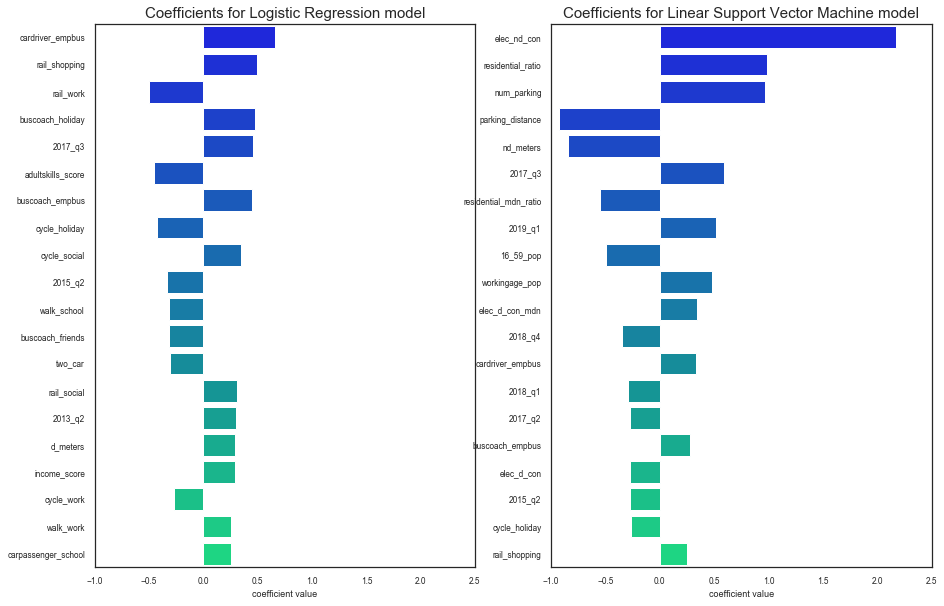

In [126]:
sns.set(font_scale=0.75)
sns.set_style("white")
fig , ax = plt.subplots(1,2,figsize=(15,10),squeeze=True)
plot_coef_feat(logr_model,df,ax[0])
plot_coef_feat(lin_svc_model,df,ax[1])
ax[0].set_title("Coefficients for Logistic Regression model",fontsize=15)
ax[1].set_title("Coefficients for Linear Support Vector Machine model",fontsize=15)
ax[0].set_xlim(-1,2.5)
ax[1].set_xlim(-1,2.5)
ax[0].set_xlabel("coefficient value")
ax[1].set_xlabel("coefficient value")

plt.savefig("../reports/figures/analysis/coefficient_comparison.jpg",
                dpi=144,
                optimize=True,
                orientation='portrait',
                pad_inches=0.9);

In [179]:
pd.set_option('display.max_rows',200)
X = df.iloc[:,4:-1]
y = df.charge_points.apply(lambda x : 1 if x > 0 else 0).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0,shuffle=True, stratify=y)

model = sm.Logit(y_train,X_train)
results = model.fit_regularized()
results_summary = results.summary()
results_as_html = results_summary.tables[1].as_html()
table = pd.read_html(results_as_html, header=0, index_col=0)[0]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5273830236518436
            Iterations: 751
            Function evaluations: 754
            Gradient evaluations: 751


In [187]:
final_table = table.sort_values(by='P>|z|').iloc[:17,:]
final_table['abs_coef'] = final_table.coef.apply(lambda x : abs(x))
final_table = final_table.sort_values(by='abs_coef',ascending=False)
final_table

,coef,std err,z,P>|z|,[0.025,0.975],abs_coef
elec_nd_con,11.9235,4.963,2.403,0.016,2.197,21.650,11.9235
residential_ratio,3.4996,1.231,2.842,0.004,1.086,5.913,3.4996
residential_mdn_ratio,-2.4651,1.012,-2.436,0.015,-4.448,-0.482,2.4651
2017_q3,1.8662,0.652,2.861,0.004,0.588,3.145,1.8662
2019_q1,1.5646,0.744,2.102,0.036,0.105,3.024,1.5646
elec_d_con_mdn,1.4911,0.551,2.705,0.007,0.411,2.571,1.4911
cardriver_empbus,1.0178,0.378,2.695,0.007,0.278,1.758,1.0178
2015_q2,-0.7841,0.352,-2.229,0.026,-1.473,-0.095,0.7841
rail_shopping,0.7437,0.274,2.716,0.007,0.207,1.280,0.7437
rail_work,-0.6980,0.259,-2.700,0.007,-1.205,-0.191,0.6980


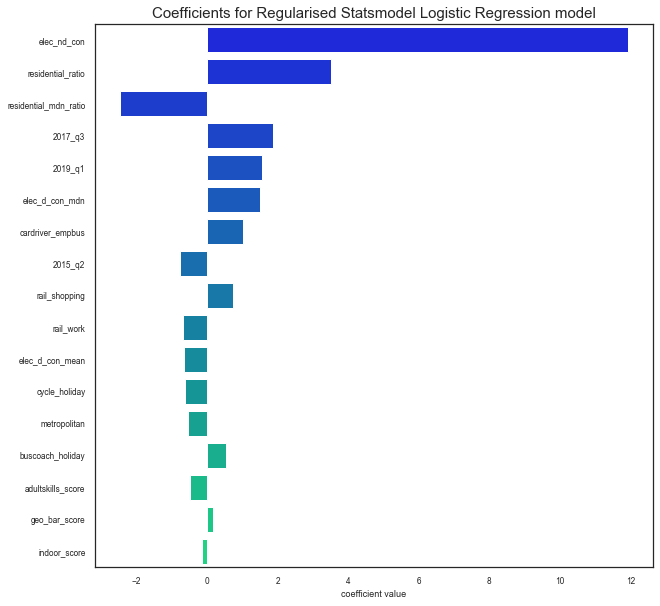

In [193]:
fig, ax = plt.subplots(figsize=(10,10))
sns.barplot('coef',
                y=final_table.index,
                data=final_table,
                palette='winter')
plt.xlabel("coefficient value")
plt.title("Coefficients for Regularised Statsmodel Logistic Regression model",fontsize=15)
plt.savefig("../reports/figures/analysis/statsmodel_coefficient.jpg",
                dpi=144,
                optimize=True,
                orientation='portrait',
                pad_inches=0.9);

In [170]:
#print(tabulate(table.sort_values(by='P>|z|').iloc[:17,:],headers=['coef', 'std err', 'z', 'P>|z|', '[0.025', '0.975]'],tablefmt="github"))

|     **variable**      |**coef** |**std err**|  **z** |**P>[z]**|**0.025** |**0.975** |
|-----------------------|---------|-----------|--------|---------|----------|----------|
| metropolitan          | -0.5459 |     0.082 | -6.656 |   0     |   -0.707 |   -0.385 |
| adultskills_score     | -0.4896 |     0.118 | -4.132 |   0     |   -0.722 |   -0.257 |
| 2017_q3               |  1.8683 |     0.652 |  2.864 |   0.004 |    0.59  |    3.147 |
| residential_ratio     |  3.4951 |     1.231 |  2.839 |   0.005 |    1.082 |    5.908 |
| indoor_score          | -0.1509 |     0.054 | -2.779 |   0.005 |   -0.257 |   -0.044 |
| elec_d_con_mdn        |  1.4876 |     0.551 |  2.699 |   0.007 |    0.407 |    2.568 |
| rail_work             | -0.6978 |     0.259 | -2.699 |   0.007 |   -1.204 |   -0.191 |
| cardriver_empbus      |  1.0182 |     0.378 |  2.696 |   0.007 |    0.278 |    1.758 |
| rail_shopping         |  0.7446 |     0.274 |  2.719 |   0.007 |    0.208 |    1.281 |
| residential_mdn_ratio | -2.4575 |     1.012 | -2.429 |   0.015 |   -4.44  |   -0.475 |
| elec_nd_con           | 11.9535 |     4.962 |  2.409 |   0.016 |    2.227 |   21.68  |
| geo_bar_score         |  0.1562 |     0.068 |  2.3   |   0.021 |    0.023 |    0.289 |
| buscoach_holiday      |  0.5403 |     0.238 |  2.274 |   0.023 |    0.075 |    1.006 |
| 2015_q2               | -0.7837 |     0.352 | -2.228 |   0.026 |   -1.473 |   -0.094 |
| elec_d_con_mean       | -0.6476 |     0.302 | -2.143 |   0.032 |   -1.24  |   -0.055 |
| 2019_q1               |  1.5625 |     0.744 |  2.099 |   0.036 |    0.103 |    3.022 |
| cycle_holiday         | -0.6321 |     0.321 | -1.968 |   0.049 |   -1.262 |   -0.003 |